July 11, 2024 Project Collab Notebook

# Introduction


Fake news classification [based on the liar liar dataset](https://arxiv.org/pdf/1705.00648v1).

### Imports

In [ ]:
# Imports
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch libraries
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor
from collections import Counter
import torch.nn.functional as F
import torch.optim as optim

# NLP libraries
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

Loading Liar Dataset

In [ ]:
data_path = '/content/'

In [ ]:
# For example, Mitt Romney has a credit
# history vector h = {19, 32, 34, 58, 33}, which corresponds to his counts of “pants on fire”, “false”,
# “barely true”, “half true”, “mostly true” for historical statements

# pof = pants on fire
df_train = pd.read_csv(data_path + 'train.tsv', sep='\t', names=["source", "truth_class",
                                                              "statement", "area", "speaker",
                                                              "speaker_role", "location", "party",
                                                              "pof_count", "false_count", "barely_true_count", "half_true_count",
                                                              "mostly_true_count", "media"])
df_train['type'] = 0

df_test = pd.read_csv(data_path +  'test.tsv', sep='\t', names=["source", "truth_class",
                                                              "statement", "area", "speaker",
                                                              "speaker_role", "location", "party",
                                                              "pof_count", "false_count", "barely_true_count", "half_true_count",
                                                              "mostly_true_count", "media"])
df_test['type'] = 2

df_valid = pd.read_csv(data_path + 'valid.tsv', sep='\t', names=["source", "truth_class",
                                                              "statement", "area", "speaker",
                                                              "speaker_role", "location", "party",
                                                              "pof_count", "false_count", "barely_true_count", "half_true_count",
                                                              "mostly_true_count", "media"])
df_valid['type'] = 1


In [ ]:
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)


(10240, 15)
(1284, 15)
(1267, 15)


In [ ]:
df_train.shape

(10240, 15)

In [ ]:
# Concatenate all dataset for cleaning
df_all = pd.concat([df_train, df_valid, df_test])

In [ ]:
# Reset index to ensure no duplicate index values
df_all = df_all.reset_index(drop=True)

In [ ]:
# df_all.columns

Index(['source', 'truth_class', 'statement', 'area', 'speaker', 'speaker_role',
       'location', 'party', 'pof_count', 'false_count', 'barely_true_count',
       'half_true_count', 'mostly_true_count', 'media', 'type'],
      dtype='object')

In [ ]:
df_all['statement'][0]

'Says the Annies List political group supports third-trimester abortions on demand.'

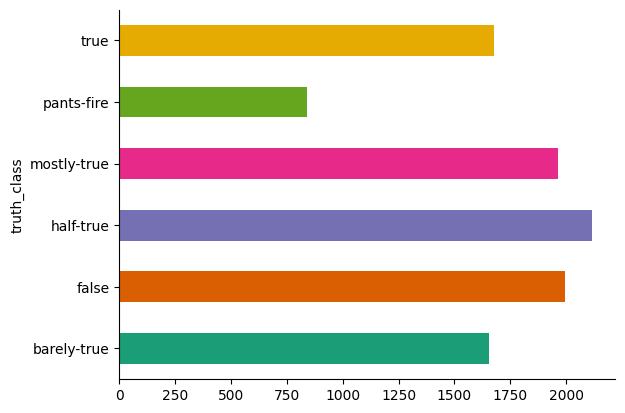

In [ ]:
# @title truth-class

from matplotlib import pyplot as plt
import seaborn as sns
df_train.groupby('truth_class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12791 entries, 0 to 12790
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   source             12791 non-null  object 
 1   truth_class        12791 non-null  object 
 2   statement          12791 non-null  object 
 3   area               12789 non-null  object 
 4   speaker            12789 non-null  object 
 5   speaker_role       9223 non-null   object 
 6   location           10040 non-null  object 
 7   party              12789 non-null  object 
 8   pof_count          12789 non-null  float64
 9   false_count        12789 non-null  float64
 10  barely_true_count  12789 non-null  float64
 11  half_true_count    12789 non-null  float64
 12  mostly_true_count  12789 non-null  float64
 13  media              12660 non-null  object 
 14  type               12791 non-null  int64  
dtypes: float64(5), int64(1), object(9)
memory usage: 1.5+ MB


In [ ]:
# add a column for statement counts
df_all['statement_count'] = 0

role_counts = df_all['speaker'].value_counts()

# Map the counts to the 'count' column
df_all['statement_count'] = df_all['speaker'].map(role_counts)

# make the counts percents
df_all['pof_percent'] = df_all['pof_count']/df_all['statement_count']
df_all['false_percent'] = df_all['false_count']/df_all['statement_count']
df_all['barely_true_percent'] = df_all['barely_true_count']/df_all['statement_count']
df_all['half_true_percent'] = df_all['half_true_count']/df_all['statement_count']
df_all['mostly_true_percent'] = df_all['mostly_true_count']/df_all['statement_count']
df_all['true_percent'] = 1 - (df_all['pof_percent'] + df_all['false_percent'] + df_all['barely_true_percent']
                              + df_all['half_true_percent'] +  df_all['mostly_true_percent'])

In [ ]:
# translate pants-fire, false, barelytrue, half-true, mostly-true, and true to 0, 1, 2, 3, 4, 5
mapping_dict = {
    "pants-fire": 0,
    "false": 1,
    "barely-true": 2,
    "half-true": 3,
    "mostly-true": 4,
    "true": 5
}

# Apply the mapping to the "truth_class" column
df_all['truth_map'] = df_all['truth_class'].map(mapping_dict)


In [ ]:
df_all.columns

Index(['source', 'truth_class', 'statement', 'area', 'speaker', 'speaker_role',
       'location', 'party', 'pof_count', 'false_count', 'barely_true_count',
       'half_true_count', 'mostly_true_count', 'media', 'type',
       'statement_count', 'pof_percent', 'false_percent',
       'barely_true_percent', 'half_true_percent', 'mostly_true_percent',
       'true_percent', 'truth_map'],
      dtype='object')

In [ ]:
# df_all['true_percent'].plot(kind='bar')

In [ ]:
# # sort the true_percent column in descending order
# df_all = df_all.sort_values(by='true_percent', ascending=False)

In [ ]:
df_all

,source,truth_class,statement,area,speaker,speaker_role,location,party,pof_count,false_count,...,media,type,statement_count,pof_percent,false_percent,barely_true_percent,half_true_percent,mostly_true_percent,true_percent,truth_map
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,a mailer,0,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,a floor speech.,0,2.0,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,3
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,Denver,0,611.0,0.114566,0.116203,0.261866,0.266776,0.014730,0.225859,4
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,...,a news release,0,81.0,0.086420,0.234568,0.037037,0.061728,0.543210,0.037037,1
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,an interview on CNN,0,90.0,0.166667,0.100000,0.222222,0.211111,0.022222,0.277778,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12786,7334.json,half-true,Says his budget provides the highest state fun...,education,rick-scott,Governor,Florida,republican,28.0,23.0,...,a news conference,2,150.0,0.186667,0.153333,0.253333,0.226667,0.046667,0.133333,3
12787,9788.json,barely-true,Ive been here almost every day.,"civil-rights,crime,criminal-justice",jay-nixon,Governor,Missouri,democrat,2.0,0.0,...,"on ABC's ""This Week""",2,4.0,0.500000,0.000000,0.000000,0.250000,0.000000,0.250000,2
12788,10710.json,barely-true,"In the early 1980s, Sen. Edward Kennedy secret...","bipartisanship,congress,foreign-policy,history",mackubin-thomas-owens,"senior fellow, Foreign Policy Research Institute",Rhode Island,columnist,1.0,0.0,...,a commentary in The Providence Journal,2,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
12789,3186.json,barely-true,Says an EPA permit languished under Strickland...,"environment,government-efficiency",john-kasich,"Governor of Ohio as of Jan. 10, 2011",Ohio,republican,9.0,8.0,...,a news conference,2,67.0,0.134328,0.119403,0.149254,0.268657,0.044776,0.283582,2


In [ ]:
# Replace 'none'

df_all['party'] = df_all['party'].replace('none', 'no_affiliation')
# df_all['party'] = df_all[df_all['party'] == 'none']['party'] = 'no_affiliation'

In [ ]:
# check missing values per column
df_all.isnull().sum()

source                    0
truth_class               0
statement                 0
area                      2
speaker                   2
speaker_role           3568
location               2751
party                     2
pof_count                 2
false_count               2
barely_true_count         2
half_true_count           2
mostly_true_count         2
media                   131
type                      0
statement_count           2
pof_percent               2
false_percent             2
barely_true_percent       2
half_true_percent         2
mostly_true_percent       2
true_percent              2
truth_map                 0
dtype: int64

In [ ]:
df_all.columns

Index(['source', 'truth_class', 'statement', 'area', 'speaker', 'speaker_role',
       'location', 'party', 'pof_count', 'false_count', 'barely_true_count',
       'half_true_count', 'mostly_true_count', 'media', 'type',
       'statement_count', 'pof_percent', 'false_percent',
       'barely_true_percent', 'half_true_percent', 'mostly_true_percent',
       'true_percent', 'truth_map'],
      dtype='object')

In [ ]:
df_all.shape

(12791, 23)

processed the code to drop the "json" column

*   drop the rows where speaker is missing
*   fill missing values with "not_available"



In [ ]:
# drop columns with the source - that's the json
df_proc = df_all.drop(columns='source')

# Drop rows where 'speaker' is missing
df_proc = df_proc.dropna(subset=['speaker'])

# Replace other missing values with 'not_available'
df_proc = df_proc.fillna('not_available')

In [ ]:
# check missing values per column
df_proc.isnull().sum()

truth_class            0
statement              0
area                   0
speaker                0
speaker_role           0
location               0
party                  0
pof_count              0
false_count            0
barely_true_count      0
half_true_count        0
mostly_true_count      0
media                  0
type                   0
statement_count        0
pof_percent            0
false_percent          0
barely_true_percent    0
half_true_percent      0
mostly_true_percent    0
true_percent           0
truth_map              0
dtype: int64

In [ ]:
df_proc.shape

(12789, 22)

Start the NLP processing

In [ ]:
# example statements
df_proc['statement'].iloc[0]

'Says the Annies List political group supports third-trimester abortions on demand.'

In [ ]:
# !pip install contractions

In [ ]:
# nlp imports
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
# import contractions
import re
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

lemmatizer = WordNetLemmatizer()

# start loading language library
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df_proc['statement'][0:20]

0     Says the Annies List political group supports ...
1     When did the decline of coal start? It started...
2     Hillary Clinton agrees with John McCain "by vo...
3     Health care reform legislation is likely to ma...
4     The economic turnaround started at the end of ...
5     The Chicago Bears have had more starting quart...
6     Jim Dunnam has not lived in the district he re...
7     I'm the only person on this stage who has work...
8     However, it took $19.5 million in Oregon Lotte...
9     Says GOP primary opponents Glenn Grothman and ...
10    For the first time in history, the share of th...
11    Since 2000, nearly 12 million Americans have s...
12    When Mitt Romney was governor of Massachusetts...
13    The economy bled $24 billion due to the govern...
14    Most of the (Affordable Care Act) has already ...
15    In this last election in November, ... 63 perc...
16    McCain opposed a requirement that the governme...
17    U.S. Rep. Ron Kind, D-Wis., and his fellow

In [ ]:
# set text - include statement, area, speaker, party, media
# speaker_role, location - have a lot of missing values
text = df_proc['statement']#+ ' ' + df_proc['area'] + ' ' + df_proc['speaker'] + ' ' + df_proc['party'] + ' ' + df_proc['media']

# change "," to " "; change "." to " "
text = text.apply(lambda x: re.sub("[.]", "", x))
text = text.apply(lambda x: re.sub("[,]", "", x))

In [ ]:
# example
text.iloc[10]


'For the first time in history the share of the national popular vote margin is smaller than the Latino vote margin'

In [ ]:
# Initialize stop words and set custom stop words
# negations = set(["not", "none", "nor", "never", "neither", "against"])
negations = set(["not", "none", "nor", "never", "neither", "against",
                 "aren't", "couldn't", "didn't", "doesn't", "don't", "hadn't",
                 "hasn't", "haven't", "isn't", "mightn't", "mustn't", "needn't",
                 "shan't", "shouldn't", "wasn't", "weren't", "won't", "wouldn't", "only"])
stop_words = set(stopwords.words('english')) - negations
# stop_words

In [ ]:
# Preprocessing function

def preprocess_text(text):
  # Tokenization, lowercasing, and special character handling
  tokens = [token.text.lower() for token in nlp(text)]

  if (tokens[0] == 'says') or (tokens[0] == 'say'):
    tokens.pop(0)

  # Removing punctuation and stop words (conditionally)
  tokens = [re.sub(r'\W+', '', token) for token in tokens if token.isalnum() and token not in stop_words]

  # return the tokens in a list
  return tokens

  # returns tokens joined together
  # return ' '.join(tokens)

# apply the tokenization on the text
df_proc['processed_text'] = text.apply(preprocess_text)
processed_text = df_proc['processed_text']

now have tokenized data

In [ ]:
processed_text

0        [annies, list, political, group, supports, thi...
1        [decline, coal, start, started, natural, gas, ...
2        [hillary, clinton, agrees, john, mccain, votin...
3        [health, care, reform, legislation, likely, ma...
4               [economic, turnaround, started, end, term]
                               ...                        
12786    [budget, provides, highest, state, funding, le...
12787                                 [almost, every, day]
12788    [early, 1980s, sen, edward, kennedy, secretly,...
12789    [epa, permit, languished, strickland, new, epa...
12790    [governor, going, around, state, talking, fund...
Name: processed_text, Length: 12789, dtype: object

In [ ]:
processed_text[0]

['annies',
 'list',
 'political',
 'group',
 'supports',
 'third',
 'trimester',
 'abortions',
 'demand']

In [ ]:
## in twitter sentiment analysis - they separated data into train and test here,
## we did not

# convert the wor
# Flatten the series into a single list
flattened_list = [word for sublist in processed_text for word in sublist]

# Remove duplicates while preserving order
unique_words = list(dict.fromkeys(flattened_list))

# Create a dictionary with unique words and their corresponding indices
word_dict = {i: word for i, word in enumerate(unique_words)}

# Check for duplicates (this is just to confirm, there should be none)
values_list = list(word_dict.values())
values_set = set(values_list)

if len(values_list) != len(values_set):
    print("There are duplicates in the dictionary values.")
else:
    print("There are no duplicates in the dictionary values.")
print(word_dict)

There are no duplicates in the dictionary values.
{0: 'annies', 1: 'list', 2: 'political', 3: 'group', 4: 'supports', 5: 'third', 6: 'trimester', 7: 'abortions', 8: 'demand', 9: 'decline', 10: 'coal', 11: 'start', 12: 'started', 13: 'natural', 14: 'gas', 15: 'took', 16: 'begin', 17: 'president', 18: 'george', 19: 'w', 20: 'bushs', 21: 'administration', 22: 'hillary', 23: 'clinton', 24: 'agrees', 25: 'john', 26: 'mccain', 27: 'voting', 28: 'give', 29: 'bush', 30: 'benefit', 31: 'doubt', 32: 'iran', 33: 'health', 34: 'care', 35: 'reform', 36: 'legislation', 37: 'likely', 38: 'mandate', 39: 'free', 40: 'sex', 41: 'change', 42: 'surgeries', 43: 'economic', 44: 'turnaround', 45: 'end', 46: 'term', 47: 'chicago', 48: 'bears', 49: 'starting', 50: 'quarterbacks', 51: 'last', 52: '10', 53: 'years', 54: 'total', 55: 'number', 56: 'tenured', 57: 'uw', 58: 'faculty', 59: 'fired', 60: 'two', 61: 'decades', 62: 'jim', 63: 'dunnam', 64: 'not', 65: 'lived', 66: 'district', 67: 'represents', 68: 'only'

In [ ]:
words = Counter()
for w in flattened_list:
  words[w] += 1

sorted_words = list(words.keys())
sorted_words.sort(key=lambda w: words[w], reverse=True)
print(f"Number of different Tokens in our Dataset: {len(sorted_words)}")
print(sorted_words[:100])

Number of different Tokens in our Dataset: 13730
['percent', 'state', 'obama', 'not', 'tax', 'health', 'year', 'years', 'president', 'people', 'would', 'million', 'states', 'care', 'us', 'nt', 'one', 'jobs', 'new', 'billion', 'bill', 'texas', 'federal', 'said', 'every', 'only', 'barack', 'voted', 'budget', 'taxes', 'since', 'government', 'country', 'last', 'law', 'united', 'pay', 'plan', 'money', 'time', 'wisconsin', 'first', 'rate', 'republican', '1', 'clinton', 'americans', 'american', 'cut', 'spending', 'public', 'against', 'florida', 'get', 'two', 'even', 'school', 'senate', 'obamacare', 'insurance', 'debt', 'office', '10', 'average', 'scott', 'house', 'hillary', 'medicare', 'governor', 'america', 'gov', 'national', 'three', 'security', 'could', 'income', 'congress', 'times', 'city', 'cost', 'never', 'world', 'women', 'going', 'dollars', 'per', 'right', 'job', 'four', 'nearly', 'half', 'unemployment', 'illegal', 'less', 'bush', 'campaign', 'increase', 'county', 'democrats', 'trump'

The 15.520757465404225% most common words account for the 80.00098750105803% of the occurrences


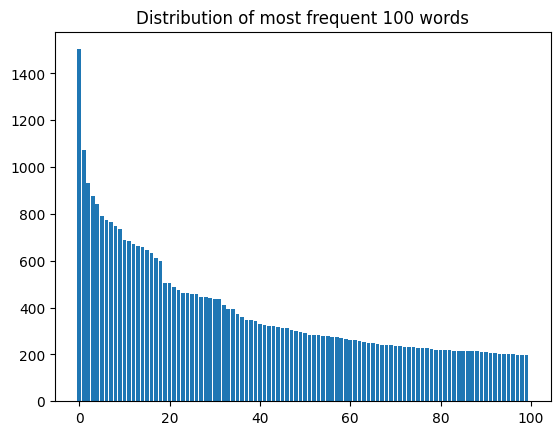

In [ ]:
# Exploratory data analysis from the twitter sentiment analysis
count_occurences = sum(words.values())

accumulated = 0
counter = 0

while accumulated < count_occurences * 0.8:
  accumulated += words[sorted_words[counter]]
  counter += 1

print(f"The {counter * 100 / len(words)}% most common words "
      f"account for the {accumulated * 100 / count_occurences}% of the occurrences")

plt.bar(range(100), [words[w] for w in sorted_words[:100]])
plt.title('Distribution of most frequent 100 words')
plt.show()

In [ ]:
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
# Set the device (check if gpu is available)
device = set_device()

In [ ]:
# From previous section, we have a list with the most used tokens
sorted_words[:30]

['percent',
 'state',
 'obama',
 'not',
 'tax',
 'health',
 'year',
 'years',
 'president',
 'people',
 'would',
 'million',
 'states',
 'care',
 'us',
 'nt',
 'one',
 'jobs',
 'new',
 'billion',
 'bill',
 'texas',
 'federal',
 'said',
 'every',
 'only',
 'barack',
 'voted',
 'budget',
 'taxes']

In [ ]:
num_words_dict = 10000
# We reserve two numbers for special tokens.
most_used_words = sorted_words[:num_words_dict-2]

In [ ]:
# dictionary to go from words to idx
word_to_idx = {}
# dictionary to go from idx to words (just in case)
idx_to_word = {}


# We include the special tokens first
PAD_token = 0
UNK_token = 1

word_to_idx['PAD'] = PAD_token
word_to_idx['UNK'] = UNK_token

idx_to_word[PAD_token] = 'PAD'
idx_to_word[UNK_token] = 'UNK'

# We popullate our dictionaries with the most used words
for num, word in enumerate(most_used_words):
  word_to_idx[word] = num + 2
  idx_to_word[num+2] = word

In [ ]:
# A function to convert list of tokens to list of indexes
def tokens_to_idx(sentences_tokens, word_to_idx):
  sentences_idx = []
  for sent in sentences_tokens:
    sent_idx = []
    for word in sent:
      if word in word_to_idx:
        sent_idx.append(word_to_idx[word])
      else:
        sent_idx.append(word_to_idx['UNK'])
    sentences_idx.append(sent_idx)
  return sentences_idx

In [ ]:
x_cv = processed_text

# truth map
y_cv = df_proc['truth_map']

In [ ]:
## separate data into train and test here

x_cv = processed_text
y_cv = df_proc['truth_map']

#(10240, 15)
# (1284, 15)
# (1267, 15)

# combine validation and training set
x_train = x_cv[df_proc['type'] == 0]
y_train = y_cv[df_proc['type'] == 0]

# # validation
x_val = x_cv[df_proc['type'] == 1]
y_val = y_cv[df_proc['type'] == 1]


# validation
x_test = x_cv[df_proc['type'] == 2]
y_test = y_cv[df_proc['type'] == 2]

In [ ]:
# train
x_train_idx = tokens_to_idx(x_train, word_to_idx)

# val
x_val_idx = tokens_to_idx(x_val, word_to_idx)

# test
x_test_idx = tokens_to_idx(x_test, word_to_idx)



In [ ]:
some_number = 1
print('Before converting: ', x_train[some_number])
print('After converting: ', x_train_idx[some_number])

Before converting:  ['decline', 'coal', 'start', 'started', 'natural', 'gas', 'took', 'started', 'begin', 'president', 'george', 'w', 'bushs', 'administration']
After converting:  [1492, 747, 696, 508, 974, 227, 107, 508, 1561, 10, 216, 569, 1427, 104]


In [ ]:
some_number = 20
print('Before converting: ', x_train[some_number])
print('After converting: ', x_train_idx[some_number])

Before converting:  ['women', 'men', 'making', 'less', 'adjust', 'inflation', 'john', 'kitzhaber', 'first', 'elected', 'governor']
After converting:  [84, 397, 289, 95, 7657, 1012, 112, 3069, 43, 365, 70]


In [ ]:
# We need all the sequences to have the same length.
# To select an adequate sequence length, let’s explore some statistics about the length of the tweets

tweet_lens = np.asarray([len(sentence) for sentence in x_train_idx])
print('Max tweet word length: ',tweet_lens.max())
print('Mean tweet word length: ',np.median(tweet_lens))
print('99% percent under: ',np.quantile(tweet_lens,0.99))

Max tweet word length:  384
Mean tweet word length:  10.0
99% percent under:  24.0


In [ ]:
 # We choose the max length
max_length = 40

# A function to make all the sequence have the same length
# Note that the output is a Numpy matrix
def padding(sentences, seq_len):
  features = np.zeros((len(sentences), seq_len),dtype=int)
  for ii, tweet in enumerate(sentences):
    len_tweet = len(tweet)
    if len_tweet != 0:
      if len_tweet <= seq_len:
        # If its shorter, we fill with zeros (the padding Token index)
        features[ii, -len(tweet):] = np.array(tweet)[:seq_len]
      if len_tweet > seq_len:
        # If its larger, we take the last 'seq_len' indexes
        features[ii, :] = np.array(tweet)[-seq_len:]
  return features

In [ ]:
# We convert our list of tokens into a numpy matrix
# where all instances have the same lenght
x_train_pad = padding(x_train_idx, max_length)
x_val_pad = padding(x_val_idx, max_length)
x_test_pad = padding(x_test_idx, max_length)

# We convert our target list a numpy matrix
y_train_np = np.asarray(y_train)
y_val_np = np.asarray(y_val)
y_test_np = np.asarray(y_test)

In [ ]:
some_number = 2
print('Before padding: ', x_train_idx[some_number])
print('After padding: ', x_train_pad[some_number])

Before padding:  [68, 47, 3435, 112, 148, 238, 260, 216, 96, 944, 3916, 293]
After padding:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   68   47 3435  112  148  238  260  216   96  944 3916  293]


In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train_np).type(torch.LongTensor))
valid_data = TensorDataset(torch.from_numpy(x_val_pad), torch.from_numpy(y_val_np).type(torch.LongTensor))
test_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test_np).type(torch.LongTensor))

# Batch size (this is an important hyperparameter)
# batch_size = 100
batch_size = 50

# dataloaders
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last = True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last = True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size,drop_last = True)

In [ ]:
# Obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.__next__()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 40])
Sample input: 
 tensor([[   0,    0,    0,  ..., 2039,  236,  559],
        [   0,    0,    0,  ...,  193, 2621,  777],
        [   0,    0,    0,  ...,  276, 1086,  438],
        ...,
        [   0,    0,    0,  ...,   56,   18,  886],
        [   0,    0,    0,  ...,  662, 3194,  805],
        [   0,    0,    0,  ...,   88,  524,  220]])
Sample input: 
 tensor([4, 3, 1, 4, 4, 3, 2, 3, 4, 1, 5, 1, 1, 2, 0, 2, 1, 1, 2, 3, 5, 2, 1, 2,
        4, 1, 4, 0, 2, 1, 4, 1, 4, 4, 3, 5, 1, 0, 3, 3, 4, 2, 5, 5, 1, 4, 0, 3,
        3, 0])


In [ ]:
class SentimentRNN(nn.Module):
  def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.1):
    super(SentimentRNN,self).__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.no_layers = no_layers
    self.vocab_size = vocab_size
    self.drop_prob = drop_prob

    # Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    # LSTM Layers
    self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                        num_layers=no_layers, batch_first=True,
                        dropout=self.drop_prob)

    # Dropout layer
    self.dropout = nn.Dropout(drop_prob)

    # Linear and Sigmoid layer
    self.fc = nn.Linear(self.hidden_dim, output_dim)
    self.sig = nn.Sigmoid()

  def forward(self,x,hidden):
    batch_size = x.size(0)

    # Embedding out
    embeds = self.embedding(x)
    #Shape: [batch_size x max_length x embedding_dim]

    # LSTM out
    lstm_out, hidden = self.lstm(embeds, hidden)
    # Shape: [batch_size x max_length x hidden_dim]

    # Select the activation of the last Hidden Layer
    lstm_out = lstm_out[:,-1,:].contiguous()
    # Shape: [batch_size x hidden_dim]

    ## You can instead average the activations across all the times
    # lstm_out = torch.mean(lstm_out, 1).contiguous()

    # Dropout and Fully connected layer
    out = self.dropout(lstm_out)
    out = self.fc(out)

    # Sigmoid function
    sig_out = self.sig(out)

    # return last sigmoid output and hidden state
    return sig_out, hidden

  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
    h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    hidden = (h0,c0)
    return hidden

In [ ]:
# Parameters of our network

# Size of our vocabulary
vocab_size = num_words_dict

# Embedding dimension
embedding_dim = 32

# Number of stacked LSTM layers
no_layers = 2

# Dimension of the hidden layer in LSTMs
hidden_dim = 64

# Dropout parameter for regularization
# output_dim = 1
output_dim = 6 # because we have 6 classes


# Dropout parameter for regularization
drop_prob = 0.25

In [ ]:
# Let's define our model
model = SentimentRNN(no_layers, vocab_size, hidden_dim,
                     embedding_dim, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(10000, 32)
  (lstm): LSTM(32, 64, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=64, out_features=6, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  378758


In [ ]:
# loss and optimization functions
lr = 0.001 #original = 0.001

# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.CrossEntropyLoss()

# We choose an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred, label):
  # outputs
  pred = torch.round(pred.squeeze())
  # print("pred:",pred)
  # print("label:",label)
  accuracy = torch.sum(pred == label.squeeze()).item()
  return accuracy

In [ ]:
# Number of training Epochs
epochs = 20

# Maximum absolute value accepted for the gradeint
clip = 5

# Initial Loss value (assumed big)
valid_loss_min = np.inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc, epoch_vl_acc = [],[]

# Train for a number of Epochs
for epoch in range(epochs):
  train_losses = []
  train_acc = 0.0
  model.train()

  for inputs, labels in train_loader:

    # Initialize hidden state
    h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
    h = tuple([each.data.to(device) for each in h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)

    # Set gradient to zero
    model.zero_grad()

    # Compute model output
    output, h = model(inputs,h)

    # Calculate the loss and perform backprop
    loss = criterion(output.squeeze(), labels)
    loss.backward()
    train_losses.append(loss.item())

    # calculating accuracy
    # print("model output:", output)
    output_argmax = torch.argmax(output, dim=1)
    accuracy = acc(output_argmax,labels)
    train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()


  # Evaluate on the validation set for this epoch
  val_losses = []
  val_acc = 0.0
  model.eval()
  for inputs, labels in valid_loader:

    # Initialize hidden state
    val_h = model.init_hidden(batch_size)
    val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
    output, val_h = model(inputs, val_h)

    # Compute Loss
    val_loss = criterion(output.squeeze(), labels)

    val_losses.append(val_loss.item())

    output_argmax = torch.argmax(output, dim=1)
    accuracy = acc(output_argmax,labels)
    val_acc += accuracy

  epoch_train_loss = np.mean(train_losses)
  epoch_val_loss = np.mean(val_losses)
  epoch_train_acc = train_acc/len(train_loader.dataset)
  epoch_val_acc = val_acc/len(valid_loader.dataset)
  epoch_tr_loss.append(epoch_train_loss)
  epoch_vl_loss.append(epoch_val_loss)
  epoch_tr_acc.append(epoch_train_acc)
  epoch_vl_acc.append(epoch_val_acc)
  print(f'Epoch {epoch+1}')
  print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
  print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
  if epoch_val_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
    valid_loss_min = epoch_val_loss
  print(25*'==')

Epoch 1
train_loss : 1.7619919461362503 val_loss : 1.7616242361068726
train_accuracy : 20.677866770853683 val_accuracy : 22.19626168224299
Validation loss decreased (inf --> 1.761624).  Saving model ...
Epoch 2
train_loss : 1.7525545779396505 val_loss : 1.753806505203247
train_accuracy : 22.689978511428013 val_accuracy : 22.0404984423676
Validation loss decreased (1.761624 --> 1.753807).  Saving model ...
Epoch 3
train_loss : 1.7402123896514667 val_loss : 1.75485249042511
train_accuracy : 24.54580972846259 val_accuracy : 24.45482866043614
Epoch 4
train_loss : 1.716291655512417 val_loss : 1.7537725210189818
train_accuracy : 27.173276030474703 val_accuracy : 23.20872274143302
Validation loss decreased (1.753807 --> 1.753773).  Saving model ...
Epoch 5
train_loss : 1.6889355211865669 val_loss : 1.7531154155731201
train_accuracy : 29.126782574721627 val_accuracy : 24.84423676012461
Validation loss decreased (1.753773 --> 1.753115).  Saving model ...
Epoch 6
train_loss : 1.660859941851859 v

In [ ]:
# # Testing phase
# model.eval()
# test_loss = 0.0
# test_correct = 0
# test_total = 0

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)

#         test_loss += loss.item() * inputs.size(0)
#         _, predicted = torch.max(outputs, 1)
#         test_total += labels.size(0)
#         test_correct += (predicted == labels).sum().item()

# test_loss /= test_total
# test_accuracy = test_correct / test_total

# print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

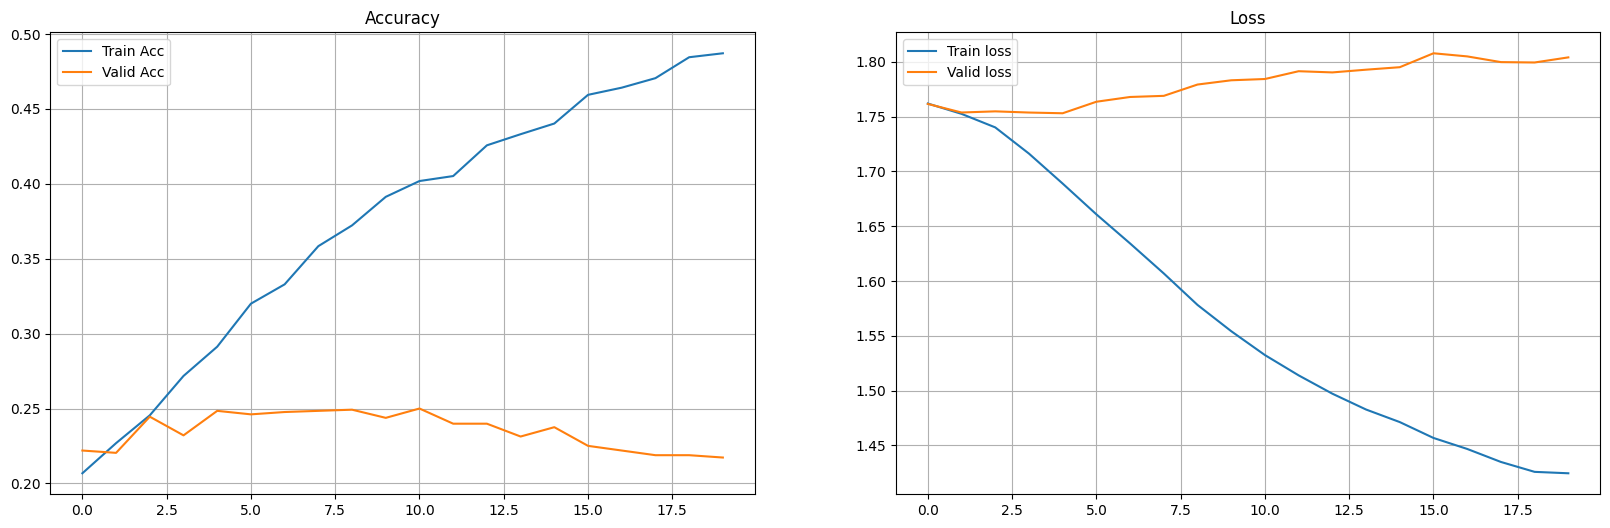

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Valid Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Valid loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [ ]:
# mport torch
# import torch.nn as nn
# import torch.nn.functional as F

# class TextClassificationModel(nn.Module):
#     def __init__(self, max_words, maxlen):
#         super(TextClassificationModel, self).__init__()
#         self.embedding = nn.Embedding(max_words, 64)
#         self.conv1d = nn.Conv1d(64, 32, 5)
#         self.global_max_pool = nn.AdaptiveMaxPool1d(1)
#         self.flatten = nn.Flatten()
#         self.dense1 = nn.Linear(32, 64)
#         self.dense2 = nn.Linear(64, 2)

In [ ]:
# def forward(self, x):
#         x = self.embedding(x)  # (batch_size, maxlen, 64)
#         x = x.permute(0, 2, 1)  # (batch_size, 64, maxlen) to (batch_size, maxlen, 64)
#         x = F.relu(self.conv1d(x))  # (batch_size, 32, maxlen - 4)
#         x = self.global_max_pool(x).squeeze(-1)  # (batch_size, 32)
#         x = self.flatten(x)  # already flattened to (batch_size, 32)
#         x = F.relu(self.dense1(x))  # (batch_size, 64)
#         x = torch.sigmoid(self.dense2(x))  # (batch_size, 2)
#         return x

# # Example usage:
# max_words = 10000
# maxlen = 100

# model = TextClassificationModel(max_words, maxlen)
# print(model)